In [1]:
from __future__ import division,print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import emcee
import corner
import batman
import copy
import time
from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from matplotlib import gridspec
import scipy.optimize as sciop

import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline

In [2]:
from __future__ import print_function, absolute_import

import numpy as np
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator, NullLocator
from matplotlib.colors import LinearSegmentedColormap, colorConverter
from matplotlib.ticker import ScalarFormatter
import logging

try:
    from scipy.ndimage import gaussian_filter
except ImportError:
    gaussian_filter = None

__all__ = ["corner", "hist2d", "quantile"]


def corner(xs, bins=20, range=None, weights=None, color="k", hist_bin_factor=1,
           smooth=None, smooth1d=None,
           labels=None, label_kwargs=None,
           show_titles=False, title_fmt=".2f", title_kwargs=None,
           truths=None, truth_color="#4682b4",
           truths2=None, truth2_color="#FF3E4C",
           truths3=None, truth3_color="#FFCD05",
           scale_hist=False, quantiles=None, verbose=False, fig=None,
           max_n_ticks=5, top_ticks=False, use_math_text=False, reverse=False,
           hist_kwargs=None, **hist2d_kwargs):
    """
    Make a *sick* corner plot showing the projections of a data set in a
    multi-dimensional space. kwargs are passed to hist2d() or used for
    `matplotlib` styling.
    Parameters
    ----------
    xs : array_like[nsamples, ndim]
        The samples. This should be a 1- or 2-dimensional array. For a 1-D
        array this results in a simple histogram. For a 2-D array, the zeroth
        axis is the list of samples and the next axis are the dimensions of
        the space.
    bins : int or array_like[ndim,]
        The number of bins to use in histograms, either as a fixed value for
        all dimensions, or as a list of integers for each dimension.
    weights : array_like[nsamples,]
        The weight of each sample. If `None` (default), samples are given
        equal weight.
    color : str
        A ``matplotlib`` style color for all histograms.
    hist_bin_factor : float or array_like[ndim,]
        This is a factor (or list of factors, one for each dimension) that
        will multiply the bin specifications when making the 1-D histograms.
        This is generally used to increase the number of bins in the 1-D plots
        to provide more resolution.
    smooth, smooth1d : float
       The standard deviation for Gaussian kernel passed to
       `scipy.ndimage.gaussian_filter` to smooth the 2-D and 1-D histograms
       respectively. If `None` (default), no smoothing is applied.
    labels : iterable (ndim,)
        A list of names for the dimensions. If a ``xs`` is a
        ``pandas.DataFrame``, labels will default to column names.
    label_kwargs : dict
        Any extra keyword arguments to send to the `set_xlabel` and
        `set_ylabel` methods.
    show_titles : bool
        Displays a title above each 1-D histogram showing the 0.5 quantile
        with the upper and lower errors supplied by the quantiles argument.
    title_fmt : string
        The format string for the quantiles given in titles. If you explicitly
        set ``show_titles=True`` and ``title_fmt=None``, the labels will be
        shown as the titles. (default: ``.2f``)
    title_kwargs : dict
        Any extra keyword arguments to send to the `set_title` command.
    range : iterable (ndim,)
        A list where each element is either a length 2 tuple containing
        lower and upper bounds or a float in range (0., 1.)
        giving the fraction of samples to include in bounds, e.g.,
        [(0.,10.), (1.,5), 0.999, etc.].
        If a fraction, the bounds are chosen to be equal-tailed.
    truths : iterable (ndim,)
        A list of reference values to indicate on the plots.  Individual
        values can be omitted by using ``None``.
    truth_color : str
        A ``matplotlib`` style color for the ``truths`` makers.
    scale_hist : bool
        Should the 1-D histograms be scaled in such a way that the zero line
        is visible?
    quantiles : iterable
        A list of fractional quantiles to show on the 1-D histograms as
        vertical dashed lines.
    verbose : bool
        If true, print the values of the computed quantiles.
    plot_contours : bool
        Draw contours for dense regions of the plot.
    use_math_text : bool
        If true, then axis tick labels for very large or small exponents will
        be displayed as powers of 10 rather than using `e`.
    reverse : bool
        If true, plot the corner plot starting in the upper-right corner
        instead of the usual bottom-left corner
    max_n_ticks: int
        Maximum number of ticks to try to use
    top_ticks : bool
        If true, label the top ticks of each axis
    fig : matplotlib.Figure
        Overplot onto the provided figure object.
    hist_kwargs : dict
        Any extra keyword arguments to send to the 1-D histogram plots.
    **hist2d_kwargs
        Any remaining keyword arguments are sent to `corner.hist2d` to generate
        the 2-D histogram plots.
    """
    if quantiles is None:
        quantiles = []
    if title_kwargs is None:
        title_kwargs = dict()
    if label_kwargs is None:
        label_kwargs = dict()

    # Try filling in labels from pandas.DataFrame columns.
    if labels is None:
        try:
            labels = xs.columns
        except AttributeError:
            pass

    # Deal with 1D sample lists.
    xs = np.atleast_1d(xs)
    if len(xs.shape) == 1:
        xs = np.atleast_2d(xs)
    else:
        assert len(xs.shape) == 2, "The input sample array must be 1- or 2-D."
        xs = xs.T
    assert xs.shape[0] <= xs.shape[1], "I don't believe that you want more " \
                                       "dimensions than samples!"

    # Parse the weight array.
    if weights is not None:
        weights = np.asarray(weights)
        if weights.ndim != 1:
            raise ValueError("Weights must be 1-D")
        if xs.shape[1] != weights.shape[0]:
            raise ValueError("Lengths of weights must match number of samples")

    # Parse the parameter ranges.
    if range is None:
        if "extents" in hist2d_kwargs:
            logging.warn("Deprecated keyword argument 'extents'. "
                         "Use 'range' instead.")
            range = hist2d_kwargs.pop("extents")
        else:
            range = [[x.min(), x.max()] for x in xs]
            # Check for parameters that never change.
            m = np.array([e[0] == e[1] for e in range], dtype=bool)
            if np.any(m):
                raise ValueError(("It looks like the parameter(s) in "
                                  "column(s) {0} have no dynamic range. "
                                  "Please provide a `range` argument.")
                                 .format(", ".join(map(
                                     "{0}".format, np.arange(len(m))[m]))))

    else:
        # If any of the extents are percentiles, convert them to ranges.
        # Also make sure it's a normal list.
        range = list(range)
        for i, _ in enumerate(range):
            try:
                emin, emax = range[i]
            except TypeError:
                q = [0.5 - 0.5*range[i], 0.5 + 0.5*range[i]]
                range[i] = quantile(xs[i], q, weights=weights)

    if len(range) != xs.shape[0]:
        raise ValueError("Dimension mismatch between samples and range")

    # Parse the bin specifications.
    try:
        bins = [int(bins) for _ in range]
    except TypeError:
        if len(bins) != len(range):
            raise ValueError("Dimension mismatch between bins and range")
    try:
        hist_bin_factor = [float(hist_bin_factor) for _ in range]
    except TypeError:
        if len(hist_bin_factor) != len(range):
            raise ValueError("Dimension mismatch between hist_bin_factor and "
                             "range")

    # Some magic numbers for pretty axis layout.
    K = len(xs)
    factor = 2.0           # size of one side of one panel
    if reverse:
        lbdim = 0.2 * factor   # size of left/bottom margin
        trdim = 0.5 * factor   # size of top/right margin
    else:
        lbdim = 0.5 * factor   # size of left/bottom margin
        trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    if fig is None:
        fig, axes = pl.subplots(K, K, figsize=(dim, dim))
    else:
        try:
            axes = np.array(fig.axes).reshape((K, K))
        except:
            raise ValueError("Provided figure has {0} axes, but data has "
                             "dimensions K={1}".format(len(fig.axes), K))

    # Format the figure.
    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    # Set up the default histogram keywords.
    if hist_kwargs is None:
        hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", color)
    if smooth1d is None:
        hist_kwargs["histtype"] = hist_kwargs.get("histtype", "step")

    for i, x in enumerate(xs):
        # Deal with masked arrays.
        if hasattr(x, "compressed"):
            x = x.compressed()

        if np.shape(xs)[0] == 1:
            ax = axes
        else:
            if reverse:
                ax = axes[K-i-1, K-i-1]
            else:
                ax = axes[i, i]
        # Plot the histograms.
        if smooth1d is None:
            bins_1d = int(max(1, np.round(hist_bin_factor[i] * bins[i])))
            n, _, _ = ax.hist(x, bins=bins_1d, weights=weights,
                              range=np.sort(range[i]), **hist_kwargs)
        else:
            if gaussian_filter is None:
                raise ImportError("Please install scipy for smoothing")
            n, b = np.histogram(x, bins=bins[i], weights=weights,
                                range=np.sort(range[i]))
            n = gaussian_filter(n, smooth1d)
            x0 = np.array(list(zip(b[:-1], b[1:]))).flatten()
            y0 = np.array(list(zip(n, n))).flatten()
            ax.plot(x0, y0, **hist_kwargs)

        if truths is not None and truths[i] is not None:
            ax.axvline(truths[i], color=truth_color)

        if truths2 is not None and truths2[i] is not None:
            ax.axvline(truths2[i], color=truth2_color)
            
        if truths3 is not None and truths3[i] is not None:
            ax.axvline(truths3[i], color=truth3_color)

        # Plot quantiles if wanted.
        if len(quantiles) > 0:
            qvalues = quantile(x, quantiles, weights=weights)
            for q in qvalues:
                ax.axvline(q, ls="dashed", color=color)

            if verbose:
                print("Quantiles:")
                print([item for item in zip(quantiles, qvalues)])

        if show_titles:
            title = None
            if title_fmt is not None:
                # Compute the quantiles for the title. This might redo
                # unneeded computation but who cares.
                q_16, q_50, q_84 = quantile(x, [0.16, 0.5, 0.84],
                                            weights=weights)
                q_m, q_p = q_50-q_16, q_84-q_50

                # Format the quantile display.
                fmt = "{{0:{0}}}".format(title_fmt).format
                title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
                title = title.format(fmt(q_50), fmt(q_m), fmt(q_p))

                # Add in the column name if it's given.
                if labels is not None:
                    title = "{0} = {1}".format(labels[i], title)

            elif labels is not None:
                title = "{0}".format(labels[i])

            if title is not None:
                if reverse:
                    ax.set_xlabel(title, **title_kwargs)
                else:
                    ax.set_title(title, **title_kwargs)

        # Set up the axes.
        ax.set_xlim(range[i])
        if scale_hist:
            maxn = np.max(n)
            ax.set_ylim(-0.1 * maxn, 1.1 * maxn)
        else:
            ax.set_ylim(0, 1.1 * np.max(n))
        ax.set_yticklabels([])
        if max_n_ticks == 0:
            ax.xaxis.set_major_locator(NullLocator())
            ax.yaxis.set_major_locator(NullLocator())
        else:
            ax.xaxis.set_major_locator(MaxNLocator(max_n_ticks, prune="lower"))
            ax.yaxis.set_major_locator(NullLocator())

        if i < K - 1:
            if top_ticks:
                ax.xaxis.set_ticks_position("top")
                [l.set_rotation(45) for l in ax.get_xticklabels()]
            else:
                ax.set_xticklabels([])
        else:
            if reverse:
                ax.xaxis.tick_top()
            [l.set_rotation(45) for l in ax.get_xticklabels()]
            if labels is not None:
                if reverse:
                    ax.set_title(labels[i], y=1.25, **label_kwargs)
                else:
                    ax.set_xlabel(labels[i], **label_kwargs)

            # use MathText for axes ticks
            ax.xaxis.set_major_formatter(
                ScalarFormatter(useMathText=use_math_text))

        for j, y in enumerate(xs):
            if np.shape(xs)[0] == 1:
                ax = axes
            else:
                if reverse:
                    ax = axes[K-i-1, K-j-1]
                else:
                    ax = axes[i, j]
            if j > i:
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                continue

            # Deal with masked arrays.
            if hasattr(y, "compressed"):
                y = y.compressed()

            hist2d(y, x, ax=ax, range=[range[j], range[i]], weights=weights,
                   color=color, smooth=smooth, bins=[bins[j], bins[i]],
                   **hist2d_kwargs)

            if truths is not None:
                if truths[i] is not None and truths[j] is not None:
                    ax.plot(truths[j], truths[i], "s", color=truth_color)
                if truths[j] is not None:
                    ax.axvline(truths[j], color=truth_color)
                if truths[i] is not None:
                    ax.axhline(truths[i], color=truth_color)
                    
            if truths2 is not None:
                if truths2[i] is not None and truths2[j] is not None:
                    ax.plot(truths2[j], truths2[i], "s", color=truth2_color)
                if truths2[j] is not None:
                    ax.axvline(truths2[j], color=truth2_color)
                if truths2[i] is not None:
                    ax.axhline(truths2[i], color=truth2_color)
                    
            if truths3 is not None:
                if truths3[i] is not None and truths3[j] is not None:
                    ax.plot(truths3[j], truths3[i], "s", color=truth3_color)
                if truths3[j] is not None:
                    ax.axvline(truths3[j], color=truth3_color)
                if truths3[i] is not None:
                    ax.axhline(truths3[i], color=truth3_color)

            if max_n_ticks == 0:
                ax.xaxis.set_major_locator(NullLocator())
                ax.yaxis.set_major_locator(NullLocator())
            else:
                ax.xaxis.set_major_locator(MaxNLocator(max_n_ticks,
                                                       prune="lower"))
                ax.yaxis.set_major_locator(MaxNLocator(max_n_ticks,
                                                       prune="lower"))

            if i < K - 1:
                ax.set_xticklabels([])
            else:
                if reverse:
                    ax.xaxis.tick_top()
                [l.set_rotation(45) for l in ax.get_xticklabels()]
                if labels is not None:
                    ax.set_xlabel(labels[j], **label_kwargs)
                    if reverse:
                        ax.xaxis.set_label_coords(0.5, 1.4)
                    else:
                        ax.xaxis.set_label_coords(0.5, -0.3)

                # use MathText for axes ticks
                ax.xaxis.set_major_formatter(
                    ScalarFormatter(useMathText=use_math_text))

            if j > 0:
                ax.set_yticklabels([])
            else:
                if reverse:
                    ax.yaxis.tick_right()
                [l.set_rotation(45) for l in ax.get_yticklabels()]
                if labels is not None:
                    if reverse:
                        ax.set_ylabel(labels[i], rotation=-90, **label_kwargs)
                        ax.yaxis.set_label_coords(1.3, 0.5)
                    else:
                        ax.set_ylabel(labels[i], **label_kwargs)
                        ax.yaxis.set_label_coords(-0.3, 0.5)

                # use MathText for axes ticks
                ax.yaxis.set_major_formatter(
                    ScalarFormatter(useMathText=use_math_text))

    return fig


def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")

    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()


def hist2d(x, y, bins=20, range=None, weights=None, levels=None, smooth=None,
           ax=None, color=None, quiet=False,
           plot_datapoints=False, plot_density=True,
           plot_contours=True, no_fill_contours=False, fill_contours=False,
           contour_kwargs=None, contourf_kwargs=None, data_kwargs=None,
           **kwargs):
    """
    Plot a 2-D histogram of samples.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    y : array_like[nsamples,]
       The samples.
    quiet : bool
        If true, suppress warnings for small datasets.
    levels : array_like
        The contour levels to draw.
    ax : matplotlib.Axes
        A axes instance on which to add the 2-D histogram.
    plot_datapoints : bool
        Draw the individual data points.
    plot_density : bool
        Draw the density colormap.
    plot_contours : bool
        Draw the contours.
    no_fill_contours : bool
        Add no filling at all to the contours (unlike setting
        ``fill_contours=False``, which still adds a white fill at the densest
        points).
    fill_contours : bool
        Fill the contours.
    contour_kwargs : dict
        Any additional keyword arguments to pass to the `contour` method.
    contourf_kwargs : dict
        Any additional keyword arguments to pass to the `contourf` method.
    data_kwargs : dict
        Any additional keyword arguments to pass to the `plot` method when
        adding the individual data points.
    """
    if ax is None:
        ax = pl.gca()

    # Set the default range based on the data range if not provided.
    if range is None:
        if "extent" in kwargs:
            logging.warn("Deprecated keyword argument 'extent'. "
                         "Use 'range' instead.")
            range = kwargs["extent"]
        else:
            range = [[x.min(), x.max()], [y.min(), y.max()]]

    # Set up the default plotting arguments.
    if color is None:
        color = "k"

    # Choose the default "sigma" contour levels.
    if levels is None:
        levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

    # This is the color map for the density plot, over-plotted to indicate the
    # density of the points near the center.
    density_cmap = LinearSegmentedColormap.from_list(
        "density_cmap", [color, (1, 1, 1, 0)])

    # This color map is used to hide the points at the high density areas.
    white_cmap = LinearSegmentedColormap.from_list(
        "white_cmap", [(1, 1, 1), (1, 1, 1)], N=2)

    # This "color map" is the list of colors for the contour levels if the
    # contours are filled.
    rgba_color = colorConverter.to_rgba(color)
    contour_cmap = [list(rgba_color) for l in levels] + [rgba_color]
    for i, l in enumerate(levels):
        contour_cmap[i][-1] *= float(i) / (len(levels)+1)

    # We'll make the 2D histogram to directly estimate the density.
    try:
        H, X, Y = np.histogram2d(x.flatten(), y.flatten(), bins=bins,
                                 range=list(map(np.sort, range)),
                                 weights=weights)
    except ValueError:
        raise ValueError("It looks like at least one of your sample columns "
                         "have no dynamic range. You could try using the "
                         "'range' argument.")

    if smooth is not None:
        if gaussian_filter is None:
            raise ImportError("Please install scipy for smoothing")
        H = gaussian_filter(H, smooth)

    if plot_contours or plot_density:
        # Compute the density levels.
        Hflat = H.flatten()
        inds = np.argsort(Hflat)[::-1]
        Hflat = Hflat[inds]
        sm = np.cumsum(Hflat)
        sm /= sm[-1]
        V = np.empty(len(levels))
        for i, v0 in enumerate(levels):
            try:
                V[i] = Hflat[sm <= v0][-1]
            except:
                V[i] = Hflat[0]
        V.sort()
        m = np.diff(V) == 0
        if np.any(m) and not quiet:
            logging.warning("Too few points to create valid contours")
        while np.any(m):
            V[np.where(m)[0][0]] *= 1.0 - 1e-4
            m = np.diff(V) == 0
        V.sort()

        # Compute the bin centers.
        X1, Y1 = 0.5 * (X[1:] + X[:-1]), 0.5 * (Y[1:] + Y[:-1])

        # Extend the array for the sake of the contours at the plot edges.
        H2 = H.min() + np.zeros((H.shape[0] + 4, H.shape[1] + 4))
        H2[2:-2, 2:-2] = H
        H2[2:-2, 1] = H[:, 0]
        H2[2:-2, -2] = H[:, -1]
        H2[1, 2:-2] = H[0]
        H2[-2, 2:-2] = H[-1]
        H2[1, 1] = H[0, 0]
        H2[1, -2] = H[0, -1]
        H2[-2, 1] = H[-1, 0]
        H2[-2, -2] = H[-1, -1]
        X2 = np.concatenate([
            X1[0] + np.array([-2, -1]) * np.diff(X1[:2]),
            X1,
            X1[-1] + np.array([1, 2]) * np.diff(X1[-2:]),
        ])
        Y2 = np.concatenate([
            Y1[0] + np.array([-2, -1]) * np.diff(Y1[:2]),
            Y1,
            Y1[-1] + np.array([1, 2]) * np.diff(Y1[-2:]),
        ])

    if plot_datapoints:
        if data_kwargs is None:
            data_kwargs = dict()
        data_kwargs["color"] = data_kwargs.get("color", color)
        data_kwargs["ms"] = data_kwargs.get("ms", 2.0)
        data_kwargs["mec"] = data_kwargs.get("mec", "none")
        data_kwargs["alpha"] = data_kwargs.get("alpha", 0.1)
        ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)

    # Plot the base fill to hide the densest data points.
    if (plot_contours or plot_density) and not no_fill_contours:
        ax.contourf(X2, Y2, H2.T, [V.min(), H.max()],
                    cmap=white_cmap, antialiased=False)

    if plot_contours and fill_contours:
        if contourf_kwargs is None:
            contourf_kwargs = dict()
        contourf_kwargs["colors"] = contourf_kwargs.get("colors", contour_cmap)
        contourf_kwargs["antialiased"] = contourf_kwargs.get("antialiased",
                                                             False)
        ax.contourf(X2, Y2, H2.T, np.concatenate([[0], V, [H.max()*(1+1e-4)]]),
                    **contourf_kwargs)

    # Plot the density map. This can't be plotted at the same time as the
    # contour fills.
    elif plot_density:
        ax.pcolor(X, Y, H.max() - H.T, cmap=density_cmap)

    # Plot the contour edge colors.
    if plot_contours:
        if contour_kwargs is None:
            contour_kwargs = dict()
        contour_kwargs["colors"] = contour_kwargs.get("colors", color)
        ax.contour(X2, Y2, H2.T, V, **contour_kwargs)

    ax.set_xlim(range[0])
    ax.set_ylim(range[1])

# Text tables

## Real

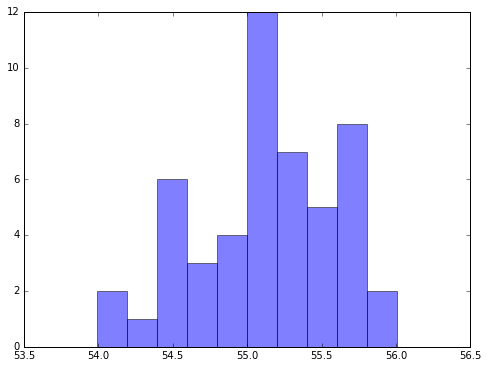

In [3]:
# AIC = -2 ln(Lmax) + 2k
# where k = 6 for single-pop models   (a_small,a_big,Rp_crit,sigma_R,a_zipf,sigma_inc)
#       k = 7 for dichotomous models  (a_small,a_big,Rp_crit,sigma_R,a_zipf,f_single,sigma_inc)


#models = ["constant","uniform","poisson","exponential","zipf","diconstant","diuniform","dipoisson","diexponential","dizipf"]
models = ["diconstant"]

for modidx, mod in enumerate(models):
    if mod[0:2] == "di":
        k = 7.
    else:
        k = 6.

    chain = np.genfromtxt("./{0}Chain.dat".format(mod),delimiter=",")
    nSteps = np.shape(chain)[0]

    randIdxs = np.random.permutation(nSteps)

    chain = chain[randIdxs]

    AICs = np.zeros((50,2))

    AICs[:,0] = np.arange(50)

    overallAIC = -2.*np.max(chain[:,-1]) + 2.*k

    for i in range(0,50):
        partChain = chain[1000*i:1000*(i+1)]
        maxLike = np.max(partChain[:,-1])

        AICs[i,1] = -2.*maxLike + 2.*k

    fig = plt.figure(figsize=(8,6))
    plt.hist(AICs[:,1],color='b',alpha=0.5)
    plt.show()

    header = "overall AIC: {0} \n partChain,AIC".format(overallAIC)

    np.savetxt("./{0}AICs.txt".format(mod),AICs,header=header,fmt="%d,%.12f",delimiter=',')

## Fakes

[[ 0.          0.         49.48015189]
 [ 0.          1.         48.94863265]
 [ 0.          2.         48.50087801]
 [ 0.          3.         48.50087801]
 [ 0.          4.         48.02446066]
 [ 0.          5.         48.60955204]
 [ 0.          6.         48.83891635]
 [ 0.          7.         48.02446066]
 [ 0.          8.         48.50087801]
 [ 0.          9.         48.02446066]
 [ 1.          0.         50.31743409]
 [ 1.          1.         51.57152948]
 [ 1.          2.         51.95838226]
 [ 1.          3.         50.93649547]
 [ 1.          4.         51.50668651]
 [ 1.          5.         52.27633292]
 [ 1.          6.         51.65614191]
 [ 1.          7.         51.35524738]
 [ 1.          8.         51.35524738]
 [ 1.          9.         51.48238773]
 [ 2.          0.         47.19661003]
 [ 2.          1.         47.55655137]
 [ 2.          2.         45.95336279]
 [ 2.          3.         45.90280724]
 [ 2.          4.         47.2216418 ]
 [ 2.          5.        

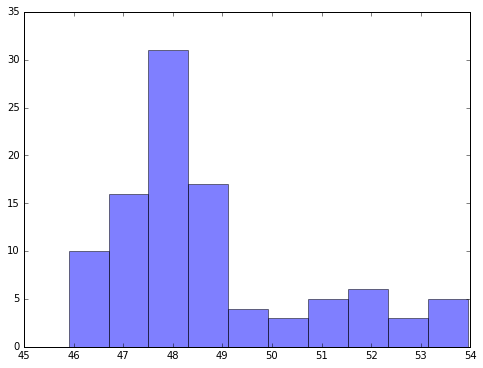

In [4]:
# AIC = -2 ln(Lmax) + 2k
# where k = 6 for single-pop models   (a_small,a_big,Rp_crit,sigma_R,a_zipf,sigma_inc)
#       k = 7 for dichotomous models  (a_small,a_big,Rp_crit,sigma_R,a_zipf,f_single,sigma_inc)

k = 6.

AICs = np.zeros((100,3))
AICs[:,0] = np.repeat(np.arange(10),10)
AICs[:,1] = np.tile(np.arange(10),10)

modd = "fitZipftofakeZipf"

for j in range(0,10):
    chain = np.genfromtxt("./fakesResults/{0}_pop{1}_10k.dat".format(modd,j),delimiter=",")
    nSteps = np.shape(chain)[0]

    randIdxs = np.random.permutation(nSteps)

    chain = chain[randIdxs]
    
    overallAIC = -2.*np.max(chain[:,-1]) + 2.*k

    for i in range(0,10):
        partChain = chain[1000*i:1000*(i+1)]
        maxLike = np.max(partChain[:,-1])

        AICs[10*j+i,2] = -2.*maxLike + 2.*k
    
print(AICs)
fig = plt.figure(figsize=(8,6))
plt.hist(AICs[:,2],color='b',alpha=0.5)
plt.show()

header = "overall AIC: {0} \n population,partChain,AIC".format(overallAIC)

np.savetxt("./{0}_AICs.txt".format(modd),AICs,header=header,fmt="%d,%d,%.12f",delimiter=',')

# Latex tables

## Real

In [5]:
# make Latex table

#pops = ["constant","uniform","poisson","zipf","exponential","diconstant","diuniform","dipoisson","dizipf","diexponential"]
pops = ["poisson","zipf","exponential","diconstant","diuniform","dipoisson","dizipf","diexponential"]

header = [r"Model",
          r"AIC"]
joinchar = " & "
results_table = open("./AIC_table.txt","w")
results_table.write(joinchar.join((map(str,header))) + r"\\" + "\n")

for popi,pop in enumerate(pops):
    if pop[0:2] == "di":
        k = 7.
    else:
        k = 6.
    linedata = [pop]
    AICs = np.genfromtxt("./{0}AICs.txt".format(pop),delimiter=",")
    chain = np.genfromtxt("./{0}Chain.dat".format(pop),delimiter=",")
    
    #if pop=="dizipf":
    #    chain = chain[chain[:,-1] < 0.]
    #    AICs = AICs[AICs[:,1] > 14.]
    #print(AICs)
    
    print(np.max(chain[:,-1]))
    aic = -2.*np.max(chain[:,-1]) + 2.*k
    aic = np.round(aic,3)
    
    print(aic)
    
    stdev = np.round(np.std(AICs[:,1]), 3)
    
    print(stdev)
    
    result = "${0}\pm{1}$".format(aic,stdev)
    linedata.append(r"{0}".format(result))
    
    results_table.write(joinchar.join((map(str, linedata))) + r"\\" + "\n")
    
results_table.close()

-30.07339367454
72.147
1.151
-20.897235364201
53.794
0.538
-22.461790717456
56.924
0.877
-19.652117903299
53.304
0.595
-20.051850417048
54.104
0.609
-20.070221708821
54.14
0.736
-19.924476478987
53.849
0.673


## Fake

In [6]:
fakes = ["fitPoissontofakePoisson","fitZipftofakePoisson","fitPoissontofakeZipf","fitZipftofakeZipf"]

header = [r"Population",
          r"AIC"]
joinchar = " & "

for j in range(0,4):
    print(fakes[j])
    results_table = open("./{0}_AIC_table.txt".format(fakes[j]),"w")
    results_table.write(joinchar.join((map(str,header))) + r"\\" + "\n")
    
    AICs = np.genfromtxt("./{0}_AICs.txt".format(fakes[j]),delimiter=",")
    #print(AICs)
    
    toWrite_AICs = []
    for i in range(0,10):
        linedata = [i]
        chain = np.genfromtxt("./fakesResults/{0}_pop{1}_10k.dat".format(fakes[j],i),delimiter=",")
        aic = -2.*np.max(chain[:,-1]) + 2.*6.
        aic = np.round(aic,3)
        toWrite_AICs.append(aic)
        #mean = np.round(np.mean(AICs[10*i:11*i,1]), 3)
        stdev = np.round(np.std(AICs[10*i:11*i,1]), 3)

        result = "${0}\pm{1}$".format(aic,stdev)
        linedata.append(r"{0}".format(result))
        
        results_table.write(joinchar.join((map(str, linedata))) + r"\\" + "\n")
    
    results_table.close()
    
    toWrite_AICs = np.array(toWrite_AICs)
    print(np.min(toWrite_AICs))

fitPoissontofakePoisson


/Users/Emily/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Emily/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Emily/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


38.158
fitZipftofakePoisson
37.952
fitPoissontofakeZipf
53.591
fitZipftofakeZipf
45.903


In [7]:
fakes = ["fitPoissontofakePoisson","fitZipftofakePoisson","fitPoissontofakeZipf","fitZipftofakeZipf"]
fakeAICs = [38.158,37.952,53.591,45.903]

header = [r"Test",
          r"AIC"]
joinchar = " & "

results_table = open("./fakes_AIC_table.txt","w")
results_table.write(joinchar.join((map(str,header))) + r"\\" + "\n")

for fakei,fake in enumerate(fakes):
    linedata = [fake]
    AICs = np.genfromtxt("./{0}_AICs.txt".format(fake),delimiter=",")
    #print(AICs)
    #mean = np.round(np.mean(AICs[:,1]), 3)
    aic = fakeAICs[fakei]
    aic = np.round(aic,3)
    stdev = np.round(np.std(AICs[:,1]), 3)
    
    result = "${0}\pm{1}$".format(aic,stdev)
    linedata.append(r"{0}".format(result))
    
    results_table.write(joinchar.join((map(str, linedata))) + r"\\" + "\n")
    
results_table.close()